In [ ]:
'Heatmaps'

In [ ]:
import os
import glob
import pandas as pd
import re
import plotly.express as px
import numpy as np

def render_heatmap_from_data(heatmap_data, filepath=None, save_dir=None):
    heatmap_matrix = heatmap_data.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio', aggfunc=np.mean)

    title = "LCS Ratio for Each Mutation"
    filename = "heatmap.png"
    if filepath:
        basename = os.path.basename(filepath)
        match = re.match(r"([A-Z0-9]+)_(\d+)_heatmap_data\.csv", basename)
        if match:
            uniprot_id = match.group(1)
            position = match.group(2)
            title = f"Normalized LCS values for {uniprot_id} at position {position}"
            filename = f"{uniprot_id}_{position}_heatmap.png"

    fig = px.imshow(
        heatmap_matrix,
        labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'Normalised LCS'},
        color_continuous_scale='Temps',
        title=title
    )

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=list(range(1, 16)), ticktext=list(range(-7, 8))),
        yaxis=dict(tickmode='linear', dtick=1),
        coloraxis_colorbar=dict(
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"],
            title="Normalised LCS"
        ),
        plot_bgcolor='white'
    )

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        fig.write_image(save_path)
        print(f"Saved heatmap to {save_path}")
    else:
        fig.show()

def render_all_heatmaps(folder_path, save_dir=None):
    pattern = os.path.join(folder_path, "*_heatmap_data.csv")
    csv_files = glob.glob(pattern)

    if not csv_files:
        print(f"No heatmap data files found in {folder_path}")
        return

    for file in csv_files:
        try:
            df = pd.read_csv(file)
            print(f"\nRendering heatmap for: {os.path.basename(file)}")
            render_heatmap_from_data(df, filepath=file, save_dir=save_dir)
        except Exception as e:
            print(f"❌ Error rendering {file}: {e}")

# Path to read heatmap CSV files from heatmaps folder
heatmap_folder_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\heatmaps"

# Save images in the same folder 
heatmap_save_dir = heatmap_folder_path  

print("🔵 Rendering all heatmaps from heatmaps folder...")
render_all_heatmaps(heatmap_folder_path, save_dir=heatmap_save_dir)


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Input files and paths
INPUT_XLSX = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Heatmaps\Statistics_Input.xlsx"
HEATMAP_DIR = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Heatmaps"
OUTPUT_DIR = HEATMAP_DIR  # Save outputs to the same directory

# Load metadata from Excel
df_meta = pd.read_excel(INPUT_XLSX)

# Build mapping from possible filenames to their variant type
filename_to_type = {}
for _, row in df_meta.iterrows():
    uniprot = row['UniProt_ID']
    aa_pos = row['Amino_acid_position']
    ref_pos = row['Reference_Position']
    variant_type = row['Type'].strip().capitalize()

    filename_to_type[f"{uniprot}_{aa_pos}_heatmap_data.csv"] = variant_type
    filename_to_type[f"{uniprot}_{ref_pos}_heatmap_data.csv"] = variant_type

# Load heatmap and extract LCS values
def load_heatmap_matrix(filepath):
    df = pd.read_csv(filepath)
    return df.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')

def get_all_lcs_values(matrix): #generates all lcs values csv
    return matrix.values.flatten()[~np.isnan(matrix.values.flatten())]

def get_lcs_region_values(matrix, start, end):
    region_matrix = matrix.iloc[:, start:end]
    return region_matrix.values.flatten()[~np.isnan(region_matrix.values.flatten())]

def compare_lcs_groups(benign_lcs, pathogenic_lcs):
    b_mean = np.nanmean(benign_lcs)
    b_std = np.nanstd(benign_lcs)
    p_mean = np.nanmean(pathogenic_lcs)
    p_std = np.nanstd(pathogenic_lcs)
    t_stat, p_val = ttest_ind(benign_lcs, pathogenic_lcs, nan_policy='omit')
    return b_mean, b_std, p_mean, p_std, t_stat, p_val

# Collect LCS values
benign_full, patho_full = [], []
benign_region, patho_region = [], []

# For plotting
plot_data_full = []
plot_data_region = []

for file_path in glob.glob(os.path.join(HEATMAP_DIR, "*_heatmap_data.csv")):
    filename = os.path.basename(file_path)
    variant_type = filename_to_type.get(filename, None)
    if variant_type not in ['Benign', 'Pathogenic']:
        continue

    matrix = load_heatmap_matrix(file_path)
    full_values = get_all_lcs_values(matrix)
    region_values = get_lcs_region_values(matrix, 3, 12)

    if variant_type == 'Benign':
        benign_full.extend(full_values)
        benign_region.extend(region_values)
    else:
        patho_full.extend(full_values)
        patho_region.extend(region_values)

    plot_data_full.extend([(v, variant_type, 'Full') for v in full_values])
    plot_data_region.extend([(v, variant_type, 'Region (-5 to +4)') for v in region_values])

# Convert to DataFrame for plotting
df_plot = pd.DataFrame(plot_data_full + plot_data_region, columns=['LCS_Ratio', 'Type', 'Region'])

# Run comparisons
b_mean_f, b_std_f, p_mean_f, p_std_f, t_f, pval_f = compare_lcs_groups(benign_full, patho_full)
b_mean_r, b_std_r, p_mean_r, p_std_r, t_r, pval_r = compare_lcs_groups(benign_region, patho_region)

# Filter dataframe for just the region -5 to +4
df_region = df_plot[df_plot['Region'] == 'Region (-5 to +4)']
# Calculate summary statistics
benign_vals = df_region[df_region['Type'] == 'Benign']['LCS_Ratio']
patho_vals = df_region[df_region['Type'] == 'Pathogenic']['LCS_Ratio']

# Standard deviation
benign_std = benign_vals.std()
patho_std = patho_vals.std()

# Median
benign_median = benign_vals.median()
patho_median = patho_vals.median()

# Standard Error of the Mean (SEM = std / sqrt(n))
benign_se = benign_std / np.sqrt(len(benign_vals))
patho_se = patho_std / np.sqrt(len(patho_vals))

# Annotation text
textstr = (
    f"T-statistic: {t_r:.3f}\n"
    f"P-value: {pval_r:.4f}\n"
    f"Benign Median: {benign_median:.4f}, SE: {benign_se:.4f}\n"
    f"Pathogenic Median: {patho_median:.4f}, SE: {patho_se:.4f}\n"
    f"Sample size (Benign): {len(benign_vals)}\n"
    f"Sample size (Pathogenic): {len(patho_vals)}"
)

# Calculate sample sizes
n_benign = sum(df_region['Type'] == 'Benign')
n_patho = sum(df_region['Type'] == 'Pathogenic')


# Save stats
df_stats = pd.DataFrame([
    {"Region": "Full", "Benign_Mean": b_mean_f, "Benign_Std": b_std_f,
     "Pathogenic_Mean": p_mean_f, "Pathogenic_Std": p_std_f,
     "T_stat": t_f, "P_value": pval_f},
    {"Region": "-5 to +4", "Benign_Mean": b_mean_r, "Benign_Std": b_std_r,
     "Pathogenic_Mean": p_mean_r, "Pathogenic_Std": p_std_r,
     "T_stat": t_r, "P_value": pval_r}
])
df_stats.to_csv(os.path.join(OUTPUT_DIR, "LCS_summary_statistics.csv"), index=False)


print("✔️ Analysis complete. Statistics and plot saved.")
print(f"Benign Median: {benign_median:.8f}, SE: {benign_se:.4f}")
print(f"Pathogenic Median: {patho_median:.8f}, SE: {patho_se:.4f}")



✔️ Analysis complete. Statistics and plot saved.
Benign Median: 0.11326861, SE: 0.0015
Pathogenic Median: 0.11326861, SE: 0.0012


C:\Users\ricea\AppData\Local\Temp\ipykernel_9608\3812171787.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


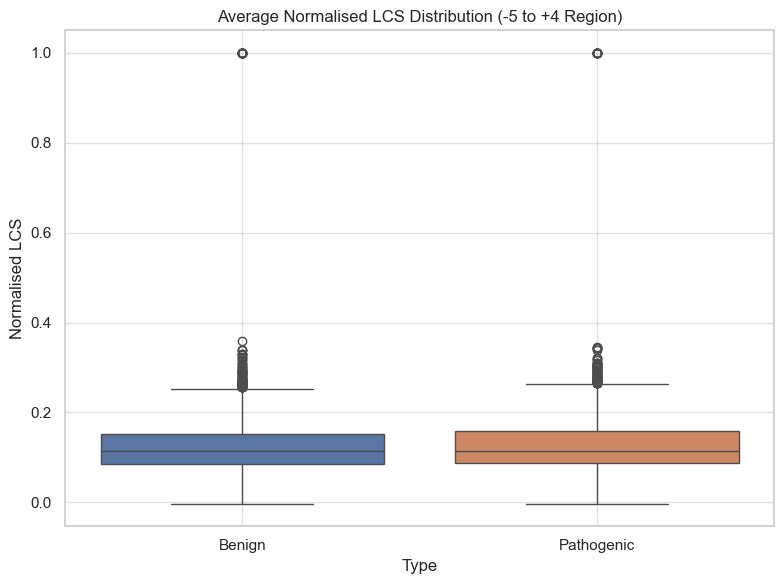

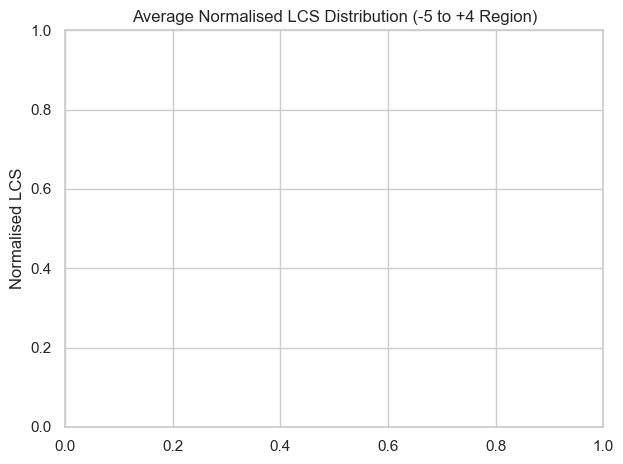

In [19]:
# Filter to -5 to +4 region
df_region = df_plot[df_plot['Region'] == 'Region (-5 to +4)']

# Get values per group (no outlier removal)
benign_vals = df_region[df_region['Type'] == 'Benign']['LCS_Ratio']
patho_vals = df_region[df_region['Type'] == 'Pathogenic']['LCS_Ratio']

# Compute stats
benign_std = benign_vals.std()
patho_std = patho_vals.std()
benign_median = benign_vals.median()
patho_median = patho_vals.median()
benign_se = benign_std / np.sqrt(len(benign_vals))
patho_se = patho_std / np.sqrt(len(patho_vals))

# Re-run t-test on full data
t_stat, p_val = ttest_ind(benign_vals, patho_vals, nan_policy='omit')

# Plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=df_region,
    x='Type',
    y='LCS_Ratio',
    order=['Benign', 'Pathogenic'],  # Ensure order
    palette={'Benign': '#4c72b0', 'Pathogenic': '#dd8452'}  # Set colors explicitly
)
plt.ylabel("Normalised LCS")

# Add gridlines
ax.grid(True, linestyle='-', alpha=0.6)

plt.title("Average Normalised LCS Distribution (-5 to +4 Region)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LCS_boxplot_region.png"), dpi=300)
plt.show()

plt.ylabel("Normalised LCS")

# Add gridlines
ax.grid(True, linestyle='-', alpha=0.6)


plt.title("Average Normalised LCS Distribution (-5 to +4 Region)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LCS_boxplot_region.png"), dpi=300)
plt.show()


C:\Users\ricea\AppData\Local\Temp\ipykernel_9608\3905516549.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_region_filtered, x='Type', y='LCS_Ratio', palette=['#4c72b0', '#dd8452'])


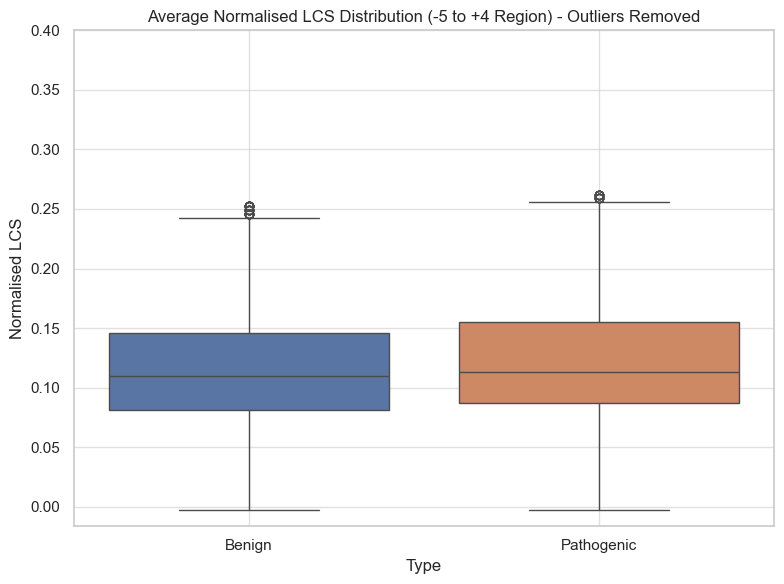

In [18]:
# Filter to -5 to +4 region
df_region = df_plot[df_plot['Region'] == 'Region (-5 to +4)']

# Function to remove outliers using 1.5 * IQR rule
def remove_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return series[(series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)]

# Remove outliers from each group
df_region_filtered = pd.concat([
    df_region[df_region['Type'] == 'Benign'].assign(LCS_Ratio=lambda x: remove_outliers(x['LCS_Ratio'])).dropna(),
    df_region[df_region['Type'] == 'Pathogenic'].assign(LCS_Ratio=lambda x: remove_outliers(x['LCS_Ratio'])).dropna()
])

# Get values per group
benign_vals = df_region_filtered[df_region_filtered['Type'] == 'Benign']['LCS_Ratio']
patho_vals = df_region_filtered[df_region_filtered['Type'] == 'Pathogenic']['LCS_Ratio']

# Compute stats
benign_std = benign_vals.std()
patho_std = patho_vals.std()
benign_median = benign_vals.median()
patho_median = patho_vals.median()
benign_se = benign_std / np.sqrt(len(benign_vals))
patho_se = patho_std / np.sqrt(len(patho_vals))

# Re-run t-test on filtered values
t_stat, p_val = ttest_ind(benign_vals, patho_vals, nan_policy='omit')

# Plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_region_filtered, x='Type', y='LCS_Ratio', palette=['#4c72b0', '#dd8452'])
plt.ylabel("Normalised LCS")


# Set Y-axis max to 0.4
ax.set_ylim(top=0.4)

ax.grid(True, linestyle='-', alpha=0.6)

plt.title("Average Normalised LCS Distribution (-5 to +4 Region) - Outliers Removed")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LCS_boxplot_region_no_outliers.png"), dpi=300)
plt.show()


In [9]:
# For full region (no outlier removal)
benign_vals_full = df_region[df_region['Type'] == 'Benign']['LCS_Ratio']
patho_vals_full = df_region[df_region['Type'] == 'Pathogenic']['LCS_Ratio']

benign_mean_full = benign_vals_full.mean()
benign_std_full = benign_vals_full.std()
patho_mean_full = patho_vals_full.mean()
patho_std_full = patho_vals_full.std()

print("Full region (no outlier removal):")
print(f"  Benign Mean: {benign_mean_full:.4f}, Std: {benign_std_full:.4f}")
print(f"  Pathogenic Mean: {patho_mean_full:.4f}, Std: {patho_std_full:.4f}")

# For outlier-removed data
benign_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Benign']['LCS_Ratio']
patho_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Pathogenic']['LCS_Ratio']

benign_mean_no_outliers = benign_vals_no_outliers.mean()
benign_std_no_outliers = benign_vals_no_outliers.std()
patho_mean_no_outliers = patho_vals_no_outliers.mean()
patho_std_no_outliers = patho_vals_no_outliers.std()

print("\nOutlier-removed region:")
print(f"  Benign Mean: {benign_mean_no_outliers:.4f}, Std: {benign_std_no_outliers:.4f}")
print(f"  Pathogenic Mean: {patho_mean_no_outliers:.4f}, Std: {patho_std_no_outliers:.4f}")


Full region (no outlier removal):
  Benign Mean: 0.1279, Std: 0.0947
  Pathogenic Mean: 0.1295, Std: 0.0818

Outlier-removed region:
  Benign Mean: 0.1177, Std: 0.0486
  Pathogenic Mean: 0.1223, Std: 0.0498


In [10]:
from scipy.stats import mannwhitneyu

# Full region (no outlier removal)
benign_vals_full = df_region[df_region['Type'] == 'Benign']['LCS_Ratio']
patho_vals_full = df_region[df_region['Type'] == 'Pathogenic']['LCS_Ratio']

stat_full, pval_full = mannwhitneyu(benign_vals_full, patho_vals_full, alternative='two-sided')

print("Mann-Whitney U test (Full region, no outlier removal):")
print(f"  U statistic: {stat_full:.3f}")
print(f"  P-value: {pval_full:.3e}\n")

# Outlier-removed region
benign_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Benign']['LCS_Ratio']
patho_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Pathogenic']['LCS_Ratio']

stat_no_outliers, pval_no_outliers = mannwhitneyu(benign_vals_no_outliers, patho_vals_no_outliers, alternative='two-sided')

print("Mann-Whitney U test (Outlier-removed region):")
print(f"  U statistic: {stat_no_outliers:.3f}")
print(f"  P-value: {pval_no_outliers:.3e}")


Mann-Whitney U test (Full region, no outlier removal):
  U statistic: 8864610.000
  P-value: 8.487e-04

Mann-Whitney U test (Outlier-removed region):
  U statistic: 8367068.000
  P-value: 8.805e-05


In [16]:
# Stats for full region (no outlier removal)
benign_vals_full = df_region[df_region['Type'] == 'Benign']['LCS_Ratio']
patho_vals_full = df_region[df_region['Type'] == 'Pathogenic']['LCS_Ratio']

benign_median_full = benign_vals_full.median()
benign_se_full = benign_vals_full.std() / np.sqrt(len(benign_vals_full))
patho_median_full = patho_vals_full.median()
patho_se_full = patho_vals_full.std() / np.sqrt(len(patho_vals_full))

from scipy.stats import ttest_ind
t_full, p_full = ttest_ind(benign_vals_full, patho_vals_full, nan_policy='omit')

print("Full region (no outlier removal):")
print(f"  T-statistic: {t_full:.3f}")
print(f"  P-value (t-test): {p_full:.4f}")
print(f"  Benign Median: {benign_median_full:.4f}, SE: {benign_se_full:.4f}")
print(f"  Pathogenic Median: {patho_median_full:.4f}, SE: {patho_se_full:.4f}")
print(f"  Sample size (Benign): {len(benign_vals_full)}")
print(f"  Sample size (Pathogenic): {len(patho_vals_full)}\n")

# Stats for outlier-removed region
benign_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Benign']['LCS_Ratio']
patho_vals_no_outliers = df_region_filtered[df_region_filtered['Type'] == 'Pathogenic']['LCS_Ratio']

benign_median_no_outliers = benign_vals_no_outliers.median()
benign_se_no_outliers = benign_vals_no_outliers.std() / np.sqrt(len(benign_vals_no_outliers))
patho_median_no_outliers = patho_vals_no_outliers.median()
patho_se_no_outliers = patho_vals_no_outliers.std() / np.sqrt(len(patho_vals_no_outliers))

t_no_outliers, p_no_outliers = ttest_ind(benign_vals_no_outliers, patho_vals_no_outliers, nan_policy='omit')

print("Outlier-removed region:")
print(f"  T-statistic: {t_no_outliers:.3f}")
print(f"  P-value (t-test): {p_no_outliers:.3e}")
print(f"  Benign Median: {benign_median_no_outliers:.4f}, SE: {benign_se_no_outliers:.4f}")
print(f"  Pathogenic Median: {patho_median_no_outliers:.4f}, SE: {patho_se_no_outliers:.4f}")
print(f"  Sample size (Benign): {len(benign_vals_no_outliers)}")
print(f"  Sample size (Pathogenic): {len(patho_vals_no_outliers)}")


Full region (no outlier removal):
  T-statistic: -0.846
  P-value (t-test): 0.3973
  Benign Median: 0.1133, SE: 0.0015
  Pathogenic Median: 0.1133, SE: 0.0012
  Sample size (Benign): 4004
  Sample size (Pathogenic): 4620

Outlier-removed region:
  T-statistic: -4.347
  P-value (t-test): 1.399e-05
  Benign Median: 0.1100, SE: 0.0008
  Pathogenic Median: 0.1133, SE: 0.0007
  Sample size (Benign): 3895
  Sample size (Pathogenic): 4520
